In [1]:
import torch 
import torch.nn as nn 
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
import time
import torchvision.transforms as transforms



In [54]:

DEVICE = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 64, 3
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 20

Device: cuda


Convolution Output Size:

$$O = \left\lfloor \frac{I + 2P - K}{S} \right\rfloor + 1$$

Transposed Convolution Output Size:

$$O = (I - 1) \times S - 2P + K$$



In [55]:

# Define your image dimensions
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# Define transformations
celeba_transforms = transforms.Compose([
    transforms.CenterCrop((160, 160)),
    transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])



# Create dataloaders directly

#issue -> not working because of some issue within the gdown library used to download datasets from torchvision
# train_dataloader = DataLoader(
#     torchvision.datasets.CelebA(
#         root='.',
#         split='train',
#         download=True,
#         transform=custom_transforms
#     ),
#     batch_size=64,
#     shuffle=True,
#     num_workers=2
# )

# val_dataloader = DataLoader(
#     torchvision.datasets.CelebA(
#         root='.',
#         split='valid',
#         download=False,
#         transform=custom_transforms
#     ),
#     batch_size=64,
#     shuffle=False,
#     num_workers=2
# )

# test_dataloader = DataLoader(
#     torchvision.datasets.CelebA(
#         root='.',
#         split='test',
#         download=False,
#         transform=custom_transforms
#     ),
#     batch_size=64,
#     shuffle=False,
#     num_workers=2
# )

# full_train_dataset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=mnist_transforms)

# # Split into training and validation
# train_size = int(0.9 * len(full_train_dataset))  # 54,000
# val_size = len(full_train_dataset) - train_size  # 6,000
# train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# # Test dataset
# test_dataset = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=mnist_transforms)

# # DataLoaders
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
# val_dataloader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
# test_dataloader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

##-----------will try to combine test and train to give more dataset to gan-----------------------
# Load training and test datasets
train_dataset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=mnist_transforms)
test_dataset  = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=mnist_transforms)

# Combine both
full_dataset = ConcatDataset([train_dataset, test_dataset])  # total 70,000 samples

# DataLoader
full_dataloader = DataLoader(
    full_dataset, batch_size=256, shuffle=True, num_workers=2
)
# Print info
print(f"Train batches: {len(full_dataloader)}")

Train batches: 274


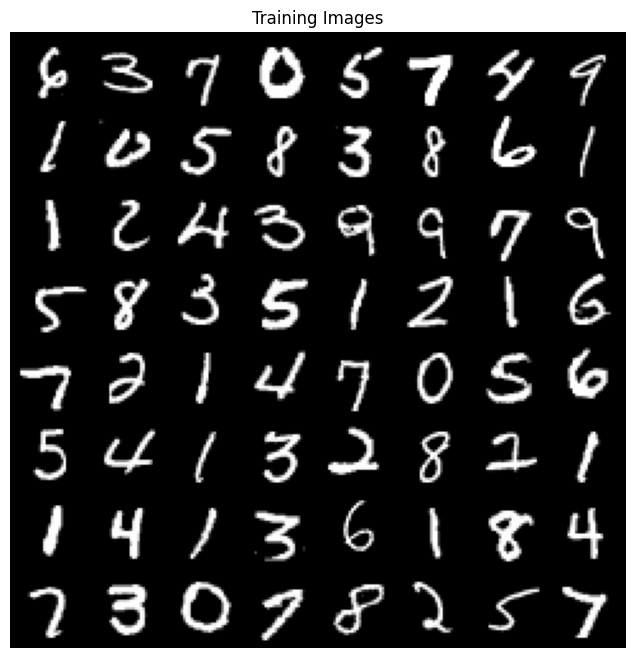

In [56]:
import numpy as np
for images, _ in full_dataloader:
    break
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))

In [57]:
class DCGAN_celeba(nn.Module):

    def __init__(self, latent_dim=100):
        super().__init__()
            
            # output_size = (input_size - 1) × stride - 2 × padding + kernel_size
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0),  # 1→4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 4→8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 8→16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 16→32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),  # 32→64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),  # 64→128
            nn.Tanh(),
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 128→64
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 64→32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # 32→16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),  # 16→8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 1, kernel_size=8, stride=1, padding=0),  # 8→1 (8-8+1=1)
            nn.Flatten(),  # [64, 1]
        )
                
            
    
    def generator_forward(self, z):
        # print(f"shape of latent space is:{z.shape}")
        img = self.generator(z)
        # print(f"shape of img after going through generator:{img.shape}")
        return img
    
    def discriminator_forward(self, img):
        # print(f"shape of img beofer going through discriminator:{img.shape}")
        logits = self.discriminator(img)
        # print(f"shape of logits:{logits.shape}")
        return logits    

In [58]:
import torch.nn as nn

class DCGAN_mnist(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()

        # Generator: latent vector z -> 1x28x28 image
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0),  # output: 128x7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 7x7 -> 14x14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1),  # 14x14 -> 28x28
            nn.Tanh(),  # output in range [-1, 1]
        )

        # Discriminator: 1x28x28 image -> single logit
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # 28 -> 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),  # 14 -> 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 7),  # 7x7 -> 1x1
            nn.Flatten(),  # shape [batch, 1]
        )

    def generator_forward(self, z):
        return self.generator(z)

    def discriminator_forward(self, img):
        return self.discriminator(img)

In [59]:
class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 image_height=28, image_width=28, color_channels=1):
        super().__init__()
        
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, image_height*image_width*color_channels),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_height*image_width*color_channels, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1), # outputs logits
            #nn.Sigmoid()
        )
    
    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1) 
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img
    
    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits


In [60]:
model = GAN()
model.to(DEVICE)
optim_gen = torch.optim.Adam(model.generator.parameters(),betas=(0.5, 0.999),lr=GENERATOR_LEARNING_RATE)
optim_discr = torch.optim.Adam(model.discriminator.parameters(),betas=(0.5, 0.999),lr=DISCRIMINATOR_LEARNING_RATE)

In [61]:
print(model)

GAN(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=784, bias=True)
    (4): Tanh()
  )
  (discriminator): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [62]:
#https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L18/04_02_dcgan-celeba.ipynb
def train_gan(num_epochs, model, optimizer_gen, optimizer_discr, 
                 latent_dim, device, train_loader, loss_fn=None,
                 logging_interval=100, 
                 save_model=None):
    
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss_fn is None:
        loss_fn = torch.nn.functional.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> 1
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------   
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       % (epoch+1, num_epochs, batch_idx, 
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict


In [63]:
def train_gan_v2(num_epochs, model, optimizer_gen, optimizer_discr, 
                 latent_dim, device, train_loader, loss='regular',
                 logging_interval=100, 
                 save_model=None):
    
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss == 'regular':
        loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
    elif loss == 'wasserstein':
        def loss_fn(y_pred, y_true):
            return -torch.mean(y_pred * y_true)
    else:
        raise ValueError('This loss is not supported.')

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            
            if loss == 'regular':
                fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
            elif loss == 'wasserstein':
                fake_labels = -real_labels # fake label = -1    
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()
            
            if loss == 'wasserstein':
                for p in model.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------   
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       % (epoch+1, num_epochs, batch_idx, 
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict


In [67]:
log_dict = train_gan_v2(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=full_dataloader,
                        logging_interval=100,
                        save_model='gan_mnist_01.pt')

Epoch: 001/020 | Batch 000/274 | Gen/Dis Loss: 1.3311/0.4487
Epoch: 001/020 | Batch 100/274 | Gen/Dis Loss: 1.3580/0.4614
Epoch: 001/020 | Batch 200/274 | Gen/Dis Loss: 1.2674/0.4645
Time elapsed: 0.12 min
Epoch: 002/020 | Batch 000/274 | Gen/Dis Loss: 1.2241/0.4942
Epoch: 002/020 | Batch 100/274 | Gen/Dis Loss: 1.2789/0.4706
Epoch: 002/020 | Batch 200/274 | Gen/Dis Loss: 1.2779/0.4751
Time elapsed: 0.24 min
Epoch: 003/020 | Batch 000/274 | Gen/Dis Loss: 1.2820/0.4818
Epoch: 003/020 | Batch 100/274 | Gen/Dis Loss: 1.2397/0.4836
Epoch: 003/020 | Batch 200/274 | Gen/Dis Loss: 1.1759/0.4867
Time elapsed: 0.37 min
Epoch: 004/020 | Batch 000/274 | Gen/Dis Loss: 1.2022/0.5016
Epoch: 004/020 | Batch 100/274 | Gen/Dis Loss: 1.2765/0.4727
Epoch: 004/020 | Batch 200/274 | Gen/Dis Loss: 1.2193/0.5129
Time elapsed: 0.49 min
Epoch: 005/020 | Batch 000/274 | Gen/Dis Loss: 1.2963/0.4413
Epoch: 005/020 | Batch 100/274 | Gen/Dis Loss: 1.2417/0.4937
Epoch: 005/020 | Batch 200/274 | Gen/Dis Loss: 1.3068/

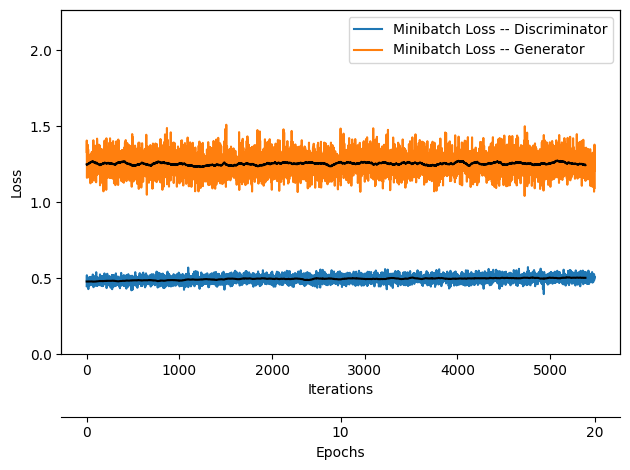

In [68]:
def plot_multiple_training_losses(losses_list, num_epochs, 
                                  averaging_iterations=100, custom_labels_list=None):

    for i,_ in enumerate(losses_list):
        if not len(losses_list[i]) == len(losses_list[0]):
            raise ValueError('All loss tensors need to have the same number of elements.')
    
    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]
    
    iter_per_epoch = len(losses_list[0]) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    
    for i, minibatch_loss_tensor in enumerate(losses_list):
        ax1.plot(range(len(minibatch_loss_tensor)),
                 (minibatch_loss_tensor),
                  label=f'Minibatch Loss{custom_labels_list[i]}')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')

        ax1.plot(np.convolve(minibatch_loss_tensor,
                             np.ones(averaging_iterations,)/averaging_iterations,
                             mode='valid'),
                 color='black')
    
    if len(losses_list[0]) < 1000:
        num_losses = len(losses_list[0]) // 2
    else:
        num_losses = 1000
    maxes = [np.max(losses_list[i][num_losses:]) for i,_ in enumerate(losses_list)]
    ax1.set_ylim([0, np.max(maxes)*1.5])
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)



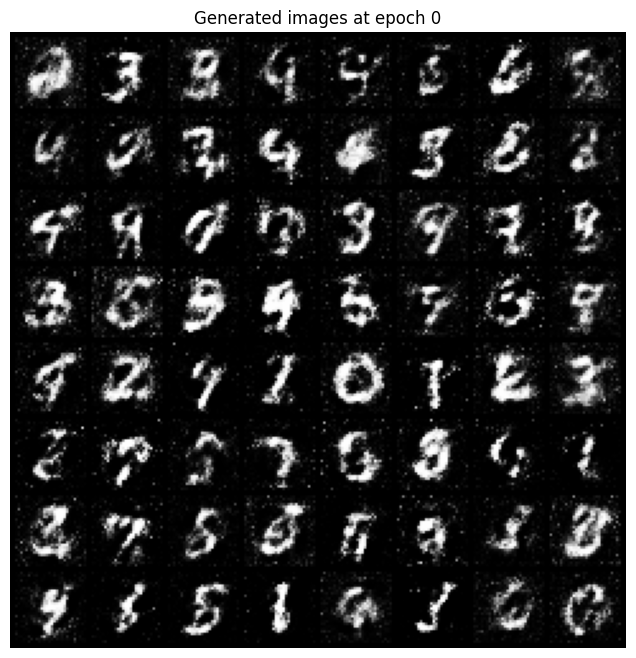

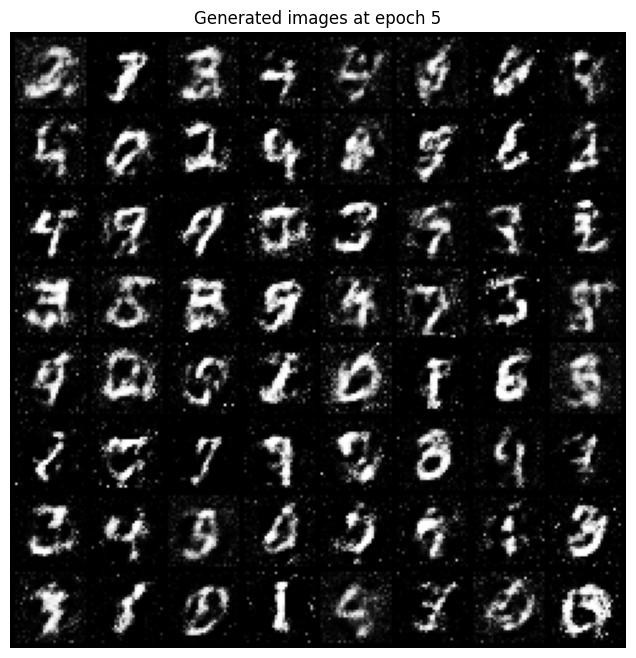

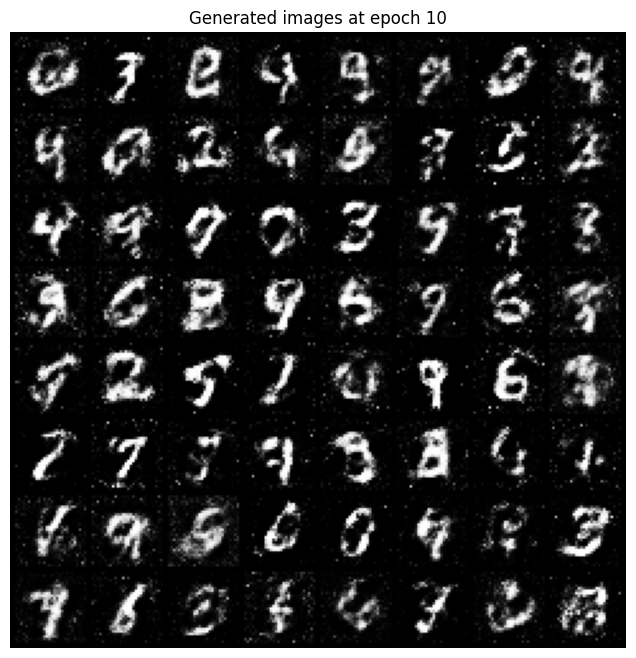

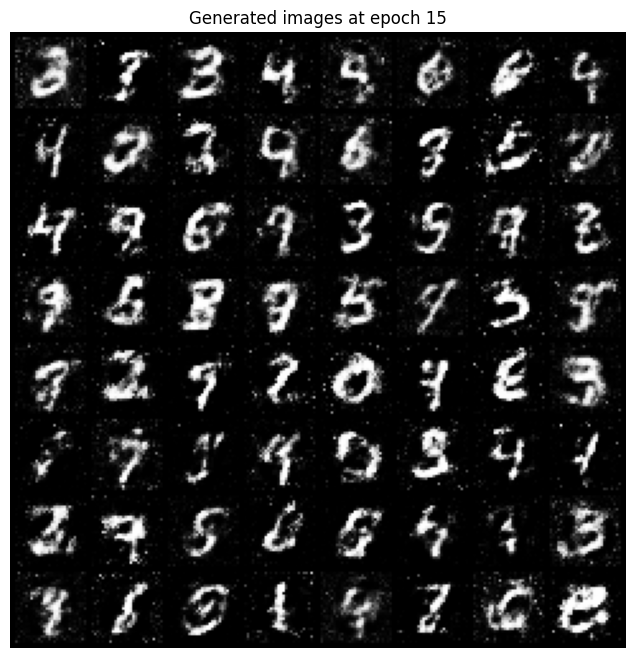

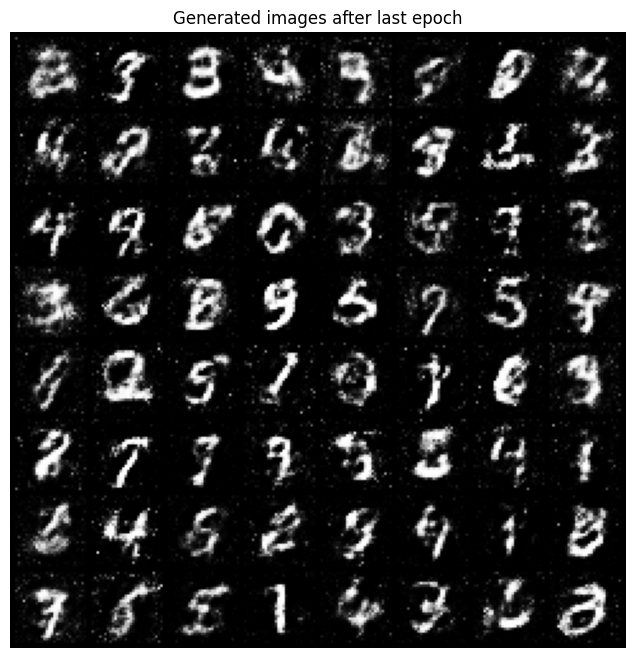

In [69]:

for i in range(0, NUM_EPOCHS, 5):
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()
